In [2]:
import os
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm


from shapely.geometry import Point,LineString
from shapely.geometry.polygon import Polygon

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

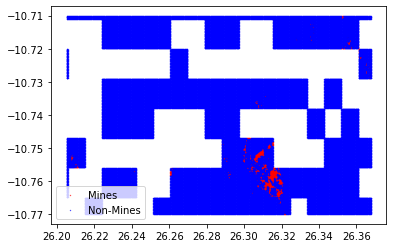

In [18]:
# Compiled csv status
# This file should not be huge (>few hundres MB)
# It should be trimmed to only contain our 'training' data points i.e. mines + (non-mining data which we want to ensure is included in the fit/optimization)
# This file will probably be a combination of several regions, which is totally fine. 
# Ensure to include Australia data set and Mojave and a city as controls for false positive exclusion data
file = '26.205_-10.77_26.368_-10.71_compiled_status.csv'
df = pd.read_csv(file)

#"""
# Quick check on mining locations in the data set
min_lon = df['Mininum Longitude']
min_lat = df['Minimum Latitude']
calc_status = df['Stat']

fig=plt.figure()
plt.scatter(min_lon.values[calc_status.values==1],min_lat.values[calc_status.values==1],c='red',s=0.1,label='Mines')
plt.scatter(min_lon.values[calc_status.values==0],min_lat.values[calc_status.values==0],c='blue',s=0.1,label='Non-Mines')
plt.legend()
plt.show()
#"""


In [4]:
# Let us define true mining areas that are within our pre-defined polygons
# This file can again contain many polygons that can be in a number of regions, not necessarily the same one.
polyfile = '26.205_-10.77_26.368_-10.71_polygons.txt' 
with open(polyfile,'r') as f:
    data = f.readlines()
npoly = len(data)

# Make the polygons and place into list
polygon = []
for i in range(npoly):
    poly = data[i].split('\n')[0]
    poly = poly.split(' ')
    npts = len(poly)
    lon = []
    lat = []
    for j in range(npts-1):
        x = poly[j].split(',')
        lon_x = x[0]
        lat_x = x[1]
        lon.append(lon_x)
        lat.append(lat_x)
    lon = np.array(lon,dtype=np.float64)
    lat = np.array(lat,dtype=np.float64)

    lons_lats_vect = np.column_stack((lon, lat))
    polygon.append(Polygon(lons_lats_vect)) 

In [5]:
def reduce_region(df,mine_pos):
    """
    args:
    df: dataframe
    mine_pos: indices of variables we wish to return. It is a vector.
    return:
    min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio
    at the indices
    """
    min_lon = df['Mininum Longitude'][mine_pos]
    min_lat = df['Minimum Latitude'][mine_pos]
    max_lon = df['Maximum Longitude'][mine_pos]
    max_lat = df['Maximum Latitude'][mine_pos]
    mine_veg_loss = df['Percent Vegetation Loss'][mine_pos]
    bare_initial = df['Percent Bare Initial'][mine_pos]
    sar = df['Percent Significant VH Values'][mine_pos]
    nirg = df['Average NIR/G'][mine_pos]
    swir1 = df['Average SWIR1/B'][mine_pos]
    nasa_elev = df['NASADEM Elevation'][mine_pos]
    gedi_loss = df['GEDI-SRTM Elevation'][mine_pos]
    gedi_qual = df['GEDI Quality Flag'][mine_pos]
    b5 = df['B5'][mine_pos]
    b6 = df['B6'][mine_pos]
    ndmi = df['NDMI'][mine_pos]
    elev_score = df['Elevation Score'][mine_pos]
    band_ratio = df['Band Variation Score'][mine_pos]
    calc_status = df['Stat'][mine_pos]


    return(min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_status)

In [6]:
# Here we are simply extracting all of our data from the pandas dataframe
idf=np.ones(df.shape[0])
idf = np.where(idf==1)[0]

# Get variables
lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat = reduce_region(df,idf)


In [7]:
# Check/Get points/pixels that are within polygons
# these will be our 'mining' areas which we will optimize thresholds for to detect 
npts = len(lon_min)
npoly = len(polygon)
idx = []
for i in tqdm(range(npts)):
    point_ll = Point(lon_min.values[i],lat_min.values[i])
    point_ur = Point(lon_max.values[i],lat_max.values[i])
    done=False
    for j in range(npoly):
        within1 = polygon[j].contains(point_ll)
        within2 = polygon[j].contains(point_ur)
        if(within1==True or within2==True):
            if(done == False):
                done=True
                idx.append(i)
idx=np.array(idx,dtype=int)

100%|██████████| 154091/154091 [00:19<00:00, 8057.35it/s]


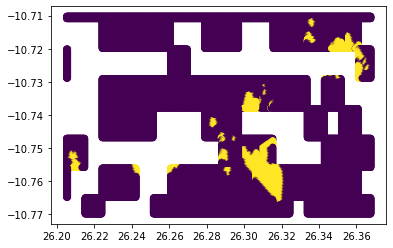

In [8]:
# Define mining regions with score of 1, non-mining=0
status = np.zeros(npts,dtype=int)
status[idx] = 1
# plot the mining/non-mining areas
fig=plt.figure()
plt.scatter(lon_min,lat_min,c=status)
#plt.scatter(lon_min[calc_stat==1],lat_min[calc_stat==1],c=calc_stat[calc_stat==1])
plt.show()


In [9]:
# we probably have too many non-mining pixels. 
# Here we will reduce the size of the non-mining data set
#Because few points are attributed to mining regions, we need to reduce the number of non-mining data points
# make the split approximately 20-80%. ie 80% of data are non-mining, 20% are mining.
# Alternaively, one can be smart about the creation on the initial .csv file we read at the start and ensure it just contains good training data and 
# a good split. In which case we can remove this section. 
count=0
idt=[]
idf=[]
for i in range(len(status)):
    if(status[i] == 1):

        
        count+=1
        idt.append(i)
    else:
        idf.append(i)

idt=np.array(idt,dtype=int)
idf=np.array(idf,dtype=int)
ratio = count/len(status) 

# we want np.sum(status)/len(status) = 0.2 ie 20% mining pixels
# we cannot increase mine pixels, but we can reduce the number of non-mining pixels 
# want len(status) = np.sum(status) / 0.2
frac = 0.2

idf = idf[0:int(np.sum(status) / frac)]


# Final array is the appending of the idf and idt indices
idx = np.hstack((idt,idf))

# reduce data set if the above is ran
lon_min = lon_min.values[idx]
lat_min =lat_min.values[idx]
lon_max = lon_max.values[idx]
lat_max = lat_max.values[idx]
mine_veg_loss = mine_veg_loss.values[idx]
bare_initial = bare_initial.values[idx]
sar = sar.values[idx]
nirg = nirg.values[idx]
swir1 = swir1.values[idx]
nasa_elev = nasa_elev.values[idx]
gedi_loss = gedi_loss.values[idx]
gedi_qual = gedi_qual.values[idx]
b5 = b5.values[idx]
b6 = b6.values[idx]
elev_score = elev_score.values[idx]
band_ratio = band_ratio.values[idx]
ndmi = ndmi.values[idx]
status = status[idx]
calc_stat = calc_stat[idx]


In [10]:
# put all the data into one array
data = np.array([lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat,status])

In [11]:
# Define our predictor variables
predictors = data[4:9,:]#np.concatenate((data[4:9,:],data[-5:-2,:]),axis=0)#,elev_score,band_ratio,b5,b6])#sar,nirg,swir1,b5,b6
X = predictors.T
y = status
print(X.shape,y.shape)

(64974, 5) (64974,)


In [12]:
# Divide up training/test data. 90/10 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)


In [13]:


#logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(penalty="none"))

logistic_regression = LogisticRegression(solver='liblinear')#penalty='none')

logistic_regression.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

In [14]:
logistic_regression.coef_


array([[-4.29065083e-03,  3.19953595e-02,  1.19562291e-02,
        -1.80534978e+01,  2.89597352e+00]])

In [15]:
accuracy = logistic_regression.score(X_test, y_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.954


In [16]:
idx = np.where(y_train==1)[0]
print("# training points total ",X_train.shape,"    Number of mines in this = ",len(idx))
result = logistic_regression.predict(X_train[idx,:])

err = y_train[idx] - result

print("Number of mines missed = ",np.sum(abs(err))))

# training points total  (64324, 5)     Number of mines in this =  10718
Number of mines missed =  1968


In [17]:
#how close was our original model
idx = np.where(data[-2,:]==1)[0]
idy = np.where(data[-1,:]==1)[0]

print("Total number of points = ",data.shape[1],"  Number of old mines = ",len(idx),"  Number of mines in polygon  = ",len(idy))

# points where mine
idx2 = np.zeros(data.shape[1])
idx2[idx] = 1
idy2 = np.zeros(data.shape[1])
idy2[idy] = 1

sc = abs(idx2 - idy2)

print("Number of mines missed from routine values = ",np.sum(sc))



Total number of points =  64974   Number of old mines =  3869   Number of mines in polygon  =  10829
Number of mines missed from routine values =  7164.0


In [ ]:
# Guys, you should check here the # of pixels incorrectly classified as mines where they should be non-mines
# The routine will be similar to the above two cells, which look at missed mines.
# You want to find out how many non-mines were missed





(64974,) (19, 64974)


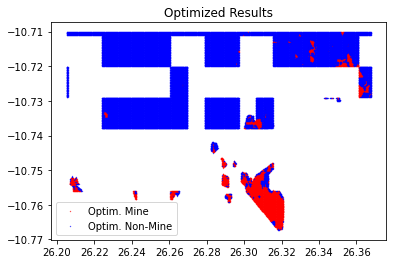

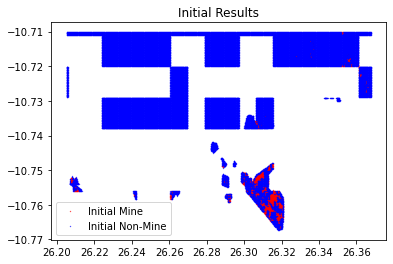

In [26]:
# let us try visualize the results of the optimization
# i.e. pass X through the regression model
result = logistic_regression.predict(X[:,:])
print(result.shape,data.shape)
fig=plt.figure()
plt.title('Optimized Results')
plt.scatter(data[0,result==1],data[1,result==1],c='red',label='Optim. Mine',s=0.1)
plt.scatter(data[0,result==0],data[1,result==0],c='blue',label='Optim. Non-Mine',s=0.1)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Initial Results')
plt.scatter(data[0,data[-2,:]==1],data[1,data[-2,:]==1],c='red',label='Initial Mine',s=0.1)
plt.scatter(data[0,data[-2,:]==0],data[1,data[-2,:]==0],c='blue',label='Initial Non-Mine',s=0.1)
plt.legend()
plt.show()


In [27]:
# export mine/ non-mine pixels to kml
from simplekml import (Kml, AltitudeMode,Color)
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from palettable import colorbrewer
import numpy.ma as ma
import matplotlib as mpl
mpl.cm.get_cmap
import matplotlib.cm as cm
from sys import exit
from tqdm import tqdm


def make_kml(lon,lat,alt,colorrange,outname):
    """
    args:
    lon,lat,alt are 1D vectors. alt is pretty much ignored as it is clamped to ground. Can be bunch of zeros
    colorrange can is also a 1D vector of constants. 
    out:
    outname specified name of output kml
    """
    kml = Kml()
    npnts = len(lon)
    for i in tqdm(range(npnts)):
        pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],altitudemode='clampToGround')#'relativeToSeaFloor') 
        #pnt.style.labelstyle.color = Color.rgb(int(colorrange[i]),0,0,255)
        pnt.style.iconstyle.color = Color.rgb(int(colorrange[i]),0,0,255)
        pnt.style.iconstyle.icon.href = 'http://earth.google.com/images/kml-icons/track-directional/track-none.png'
    kml.savekmz(outname)

In [28]:
# export optimized mine pixels to kml (not I just use )
lon = (data[0,result==1] + data[2,result==1]) / 2
lat = (data[1,result==1] + data[3,result==1]) / 2

npts = len(lon)

alt = np.zeros(npts)
color = 255 * np.ones(npts,dtype=int)

outfile = '26.205_-10.77_26.368_-10.71_optimized_pos_mines.kml'

make_kml(lon,lat,alt,color,outfile)

100%|██████████| 9723/9723 [00:00<00:00, 11171.43it/s]


In [29]:
# export old mine pixels to kml (not I just use )
lon = (data[0,data[-2,:]==1] + data[2,data[-2,:]==1]) / 2
lat = (data[1,data[-2,:]==1] + data[3,data[-2,:]==1]) / 2

npts = len(lon)

alt = np.zeros(npts)
color = 255 * np.ones(npts,dtype=int)

outfile = '26.205_-10.77_26.368_-10.71_old_pos_mines.kml'

make_kml(lon,lat,alt,color,outfile)


100%|██████████| 3869/3869 [00:00<00:00, 20859.62it/s]
